In [12]:
pip install "numpy<2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 3.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blis 1.0.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import json
import eval_metrics as em
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score

In [6]:
def get_results(folder_path):
    pred_data = pd.read_csv(f'./{folder_path}/pred.csv', names=["neutral", "happy", "angry", "sad"])
    truth_data = pd.read_csv(f'./{folder_path}/truth.csv', names=["neutral", "happy", "angry", "sad"])
    log = json.load(open(f'./{folder_path}/log.json'))
    pred = pred_data.values.tolist()
    truth = truth_data.values.tolist()
    return pred, truth, log

In [7]:
def get_eval(pred, truth):
    KL_dist = []
    R_square = []
    BC = []
    JS_distance = []
    for i in range(len(pred)):
        KL_dist.append(round(em.KL(pred[i], truth[i]),6))
        b_coefficient = em.BC(pred[i], truth[i])
        BC.append(round(b_coefficient,6))
        R_square.append(round(em.R(pred[i], truth[i]),6))
        JS_distance.append(round(em.js_distance(pred[i], truth[i]),6))

    eval_metrics = pd.DataFrame({
        'ground_truth': truth,
        'prediction': pred,
        'KL': KL_dist,
        'BC': BC,
        'R_square': R_square,
        'JS': JS_distance
    })
    eval_metrics['KL_std'] = round((eval_metrics['KL'] - eval_metrics['KL'].min()) / (eval_metrics['KL'].max() - eval_metrics['KL'].min()),6)
    return eval_metrics

In [8]:
def cal_entropy(emo_probs):
    emo_probs = np.array(emo_probs)
    non_0_probs = emo_probs[emo_probs > 0]
    entropy = abs(np.sum(non_0_probs*np.log2(non_0_probs)))
    return round(entropy,4)

def add_entropy(eval_metrics):
    entropy = []
    for i in range(len(eval_metrics)):
        entropy.append(cal_entropy(eval_metrics.iloc[i,0]))
    eval_metrics['entropy'] = entropy
    return eval_metrics

Entropy Table
* ground truth = [1.0, 0.0, 0.0, 0.9], entropy = 0
* ground truth = [0.33, 0.67, 0.0, 0.0], entropy = 0.9149
* ground truth = [0.33, 0.33, 0.0, 0.33], entropy = 1.5835
* ground truth = [0.25,0.25,0.25,0.25], entropy = 2.0

* KL: Lower is better
* BC: Larger is better
* R^2: Larger is better

In [9]:
def entropy_vs_evalmetrics(data):
    labels = sorted(data['entropy'].unique())
    grouped_KL = [data[data['entropy'] == entropy]["KL_std"].values for entropy in sorted(data['entropy'].unique())]

    for i in range(len(labels)):
        print("Number of instances for entropy = ", labels[i], ": ", len(grouped_KL[i]))
    
    plt.figure(facecolor='white')

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    ax = plt.gca()
    ax.set_facecolor('white')
    axs[0].boxplot(grouped_KL, labels = labels)
    axs[0].set_title('KL Divergence')

    grouped_BC = [data[data['entropy'] == entropy]["BC"].values for entropy in sorted(data['entropy'].unique())]
    axs[1].boxplot(grouped_BC, labels = labels)
    axs[1].set_title('BC')

    grouped_R = [data[data['entropy'] == entropy]["R_square"].values for entropy in sorted(data['entropy'].unique())]
    axs[2].boxplot(grouped_R, labels = labels)
    axs[2].set_title('R Square')

In [10]:
def js_distance(p, q):
    # Calculate M as the average of P and Q
    p= np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)

    m = 0.5 * (p + q)
    
    # Calculate JS Divergence

    js_divergence = 0.5 * em.KL(p, m) + 0.5 * em.KL(q, m)

    return np.sqrt(js_divergence)

In [8]:
js = []
for i in range(len(predts)):
    js.append(js_distance(predts[i], truthts[i]))
np.mean(js)

NameError: name 'predts' is not defined

ACC

In [11]:
def majority_agree(pred, truth):
     maj_pred_label = []
     maj_truth_label = []
     maj_pred_prob = []
     maj_truth_prob = []
     for i in range(len(pred)):
          maj_pred_prob.append(max(pred[i]))
          maj_truth_prob.append(max(truth[i]))

          maj_pred_label.append(np.argmax(pred[i]))
          maj_truth_label.append(np.argmax(truth[i]))

     return maj_pred_prob, maj_truth_prob, maj_pred_label, maj_truth_label

Expected calibration error

In [12]:
def ECE(samples, trues, n_bims = 5):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, n_bims + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = np.max(samples, axis=1)
    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1)
    true_labels = np.argmax(trues, axis=1)
    
    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece

In [13]:
def whole_eval(eval_metric, pred, truth):
    # entropy_vs_evalmetrics(eval_metric)
    print("Mean of JS", round(eval_metric['JS'].mean(),2))
    print("Mean of BC score: ", round(eval_metric['BC'].mean(),2))
    print("Mean of R square: ", round(eval_metric['R_square'].mean(),2))
    pred = np.array(pred)
    truth = np.array(truth)
    maj_pred_prob, maj_truth_prob, maj_pred_label, maj_truth_label = majority_agree(pred, truth)
    ece = ECE(pred, truth)
    acc = accuracy_score(maj_truth_label, maj_pred_label)
    print("ECE: ", round(ece[0]*100,2))
    print("UAC: ", round(acc*100,2))
    w_f1 = f1_score(maj_truth_label, maj_pred_label, average='weighted')
    print("Weighted F1: ", round(w_f1*100,2))
    return eval_metric

In [14]:
def cal_vote_by_entropy(d):
    d['true'] = d['ground_truth'].apply(lambda x: np.argmax(x))
    d['pred'] = d['prediction'].apply(lambda x: np.argmax(x))
    d = d[d['entropy'].apply(lambda x:x!= 1.5835)]

    print("overall acc: ", round((d['true'] == d['pred']).mean()*100,2))
    print("overall W-F1: ", round(f1_score(d['true'], d['pred'], average='weighted')*100,2))
    d_e = d.groupby('entropy')

    acc_by_entropy = d_e.apply(lambda x: round((x['true'] == x['pred']).mean()*100,2))
    acc_by_entropy.columns = ['entropy', 'accuracy']
    print("entropy = 0.0: acc = ", acc_by_entropy[0])
    print("entropy = 0.9149: acc = ", acc_by_entropy[0.9149])
    
    f1_by_group = d_e.apply(lambda x: round(f1_score(x['true'], x['pred'], average='weighted')*100,2))
    print("entropy = 0.0: W-F1 = :", f1_by_group[0])
    print("entropy = 0.9149: W-F1 = ", f1_by_group[0.9149])



In [50]:
all_pred, all_truth, all_log = get_results("prediction/0831_c20_fs_at")
# Impro 
eval_metric = get_eval(all_pred, all_truth)
# add entropy column
eval_metric = add_entropy(eval_metric)
df = whole_eval(eval_metric,all_pred,all_truth)

/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))


Mean of JS 0.35
Mean of BC score:  0.69
Mean of R square:  0.59
ECE:  28.88
UAC:  57.96
Weighted F1:  58.33


In [53]:
df.entropy.value_counts()

entropy
0.0000    2410
0.9149    1813
1.5835     147
Name: count, dtype: int64

In [57]:
len(df)

4370

/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_59061/250519976.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box1 = sns.boxplot(x='entropy', y='JS', data=df, ax=axs[0],palette = palette, width=0.4,
/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_59061/250519976.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box2 = sns.boxplot(x='entropy', y='BC', data=df, ax=axs[1],palette = palette, width=0.4,
/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_59061/250519976.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box3 = sns.boxplot(x=

<Figure size 640x480 with 0 Axes>

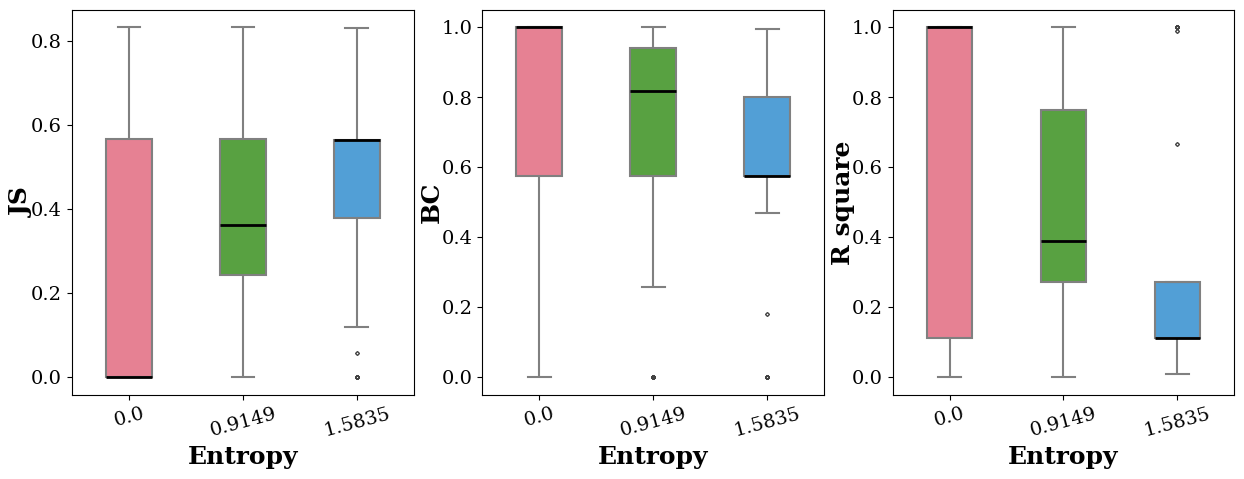

In [56]:
# def sns_vial(data):
plt.rcParams['font.family'] = 'serif'

plt.figure(facecolor='white')
palette = sns.color_palette("husl",3)  # 选择一个调色板

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='entropy', y='JS', data=df, ax=axs[0],palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
axs[0].set_ylabel('JS', fontsize = 18, labelpad=-2, fontweight='semibold')
axs[0].set_xlabel('Entropy', fontsize = 18, fontweight='semibold')
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].tick_params(axis='x', labelrotation=15)

# BC
box2 = sns.boxplot(x='entropy', y='BC', data=df, ax=axs[1],palette = palette, width=0.4,
                   boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
#sns.stripplot(x='entropy', y='BC', data=eval_metrics_ts, ax=axs[1], color=".25", jitter=True, alpha=0.4)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box2.get_lines()[i].set_color(median_color)
    box2.get_lines()[i].set_linewidth(2)
axs[1].set_ylabel('BC', fontsize = 18, labelpad=-2, fontweight='semibold')
axs[1].set_xlabel('Entropy', fontsize = 18, fontweight='semibold')
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='x', labelrotation=15)

# R Square
box3 = sns.boxplot(x='entropy', y='R_square', data=df, ax=axs[2],palette = palette, width=0.4,
                   boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
#sns.stripplot(x='entropy', y='R_square', data=eval_metrics_ts, ax=axs[2], color=".25", jitter=True, alpha=0.4)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box3.get_lines()[i].set_color(median_color)
    box3.get_lines()[i].set_linewidth(2)
axs[2].set_ylabel('R square', fontsize = 18, labelpad=-2,fontweight='semibold')
axs[2].set_xlabel('Entropy', fontsize = 18, fontweight='semibold')
axs[2].tick_params(axis='both', which='major', labelsize=14)
axs[2].tick_params(axis='x', labelrotation=15)


#sns.despine(left=True)

plt.show()

In [36]:
impro_pred = []
impro_ids = []
ID = 0
impro_truth = []
script_pred = []
script_truth = []
impro_log = []
script_log = []
i = 0

for id, values in all_log.items():
    ID += 1
    if id.split("_")[1][0:5] == "impro":
        impro_ids.append(ID)
        impro_pred.append(all_pred[i])
        impro_truth.append(all_truth[i])
        impro_log.append([id,values])
    elif id.split("_")[1][0:6] == "script":
        script_pred.append(all_pred[i])
        script_truth.append(all_truth[i])
        script_log.append([id,values])
    i += 1
print("number of utterances in impro", len(impro_pred), len(impro_truth), len(impro_ids))
script_ids = [i for i in range(4370) if i not in impro_ids]
print("number of utterances in script", len(script_pred), len(script_truth), len(script_ids))
print("Total utterances:", len(impro_pred) + len(script_pred))


number of utterances in impro 2448 2448 2448
number of utterances in script 1922 1922 1922
Total utterances: 4370


In [37]:
# Impro 
impro_eval_metric = get_eval(impro_pred, impro_truth)
# add entropy column
impro_eval_metric = add_entropy(impro_eval_metric)
impro_ds = whole_eval(impro_eval_metric,impro_pred,impro_truth)

Mean of JS 0.42
Mean of BC score:  0.58
Mean of R square:  0.56
ECE:  43.87
UAC:  53.84
Weighted F1:  52.25


/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))


In [38]:
# Script 
script_eval_metric = get_eval(script_pred, script_truth)
# add entropy column
script_eval_metric = add_entropy(script_eval_metric)
script_ds = whole_eval(script_eval_metric,script_pred,script_truth)

Mean of JS 0.61
Mean of BC score:  0.31
Mean of R square:  0.39
ECE:  71.91
UAC:  26.85
Weighted F1:  21.66


/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))


In [19]:
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, balanced_accuracy_score

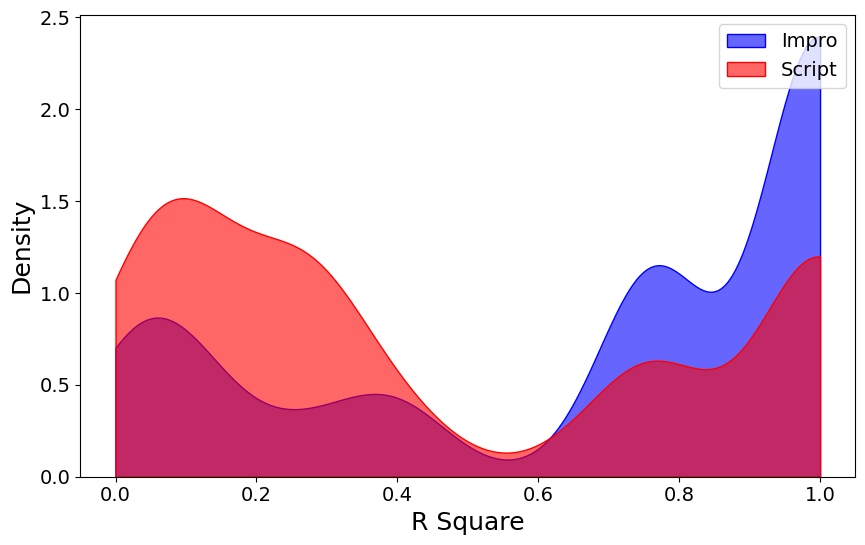

In [120]:
impro_js =  df[df['type'] == "impro"].R_square.tolist()
script_js = df[df['type'] == "script"].R_square.tolist()

# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(impro_js, fill=True, label='Impro', color='blue', alpha=0.6,clip=(0, 1))
sns.kdeplot(script_js, fill=True, label='Script', color='red', alpha=0.6,clip=(0, 1))

# Add title and labels
# plt.title("Probability Distribution of JS with Overlapping Datasets")
plt.xlabel("R Square", fontsize = 18)
plt.ylabel("Density", fontsize = 18)
plt.legend(fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

# Show the plot
plt.show()

In [12]:
'Ses01F_impro01_F001'.split("_")[1][0:5]

'impro'

In [15]:
# best_pred, best_truth, best_log = get_results("prediction/0831_c20_fs_at")

NameError: name 'best_log' is not defined

4370

number of utterances in impro 2448 2448
number of utterances in script 1922 1922


In [19]:
impro_em = get_eval(impro_pred, impro_truth)
script_em = get_eval(script_pred, script_truth)
impro_em = add_entropy(impro_em)
script_em = add_entropy(script_em)

/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))


In [20]:
best_em = get_eval(best_pred,best_truth)
best_em = add_entropy(best_em)
print("Mean of JS score: ", round(best_em['JS'].mean(),2))


/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))


Mean of JS score:  0.35


In [26]:
js_values = []
for i in range(len(impro_pred)):
    f, co = em.BC(impro_truth[i],impro_pred[i])
    js_values.append(co)
np.mean(js_values)

0.800779656862745

In [23]:
js_values = []
for i in range(len(script_pred)):
    js_values.append(em.js_distance(script_pred[i],script_truth[i]))
np.mean(js_values)

/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))


0.4623800730010348

In [ ]:
bs_values = []
for i 

In [20]:
ECE(impro_truth, impro_pred)

array([0.15463235])

In [21]:
ECE(script_truth, script_pred)

array([0.39992716])

Number of instances for entropy =  0.0 :  1486
Number of instances for entropy =  0.9149 :  936
Number of instances for entropy =  1.5835 :  26


<Figure size 432x288 with 0 Axes>

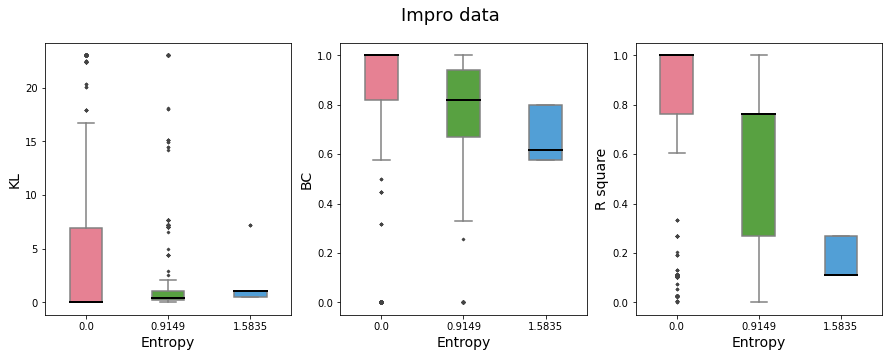

In [18]:
# def sns_vial(data):
labels = sorted(impro_em['entropy'].unique())
grouped_KL = [impro_em[impro_em['entropy'] == entropy]["KL_std"].values for entropy in sorted(impro_em['entropy'].unique())]

for i in range(len(labels)):
    print("Number of instances for entropy = ", labels[i], ": ", len(grouped_KL[i]))

plt.figure(facecolor='white')
palette = sns.color_palette("husl",3)  # 选择一个调色板

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='entropy', y='KL', data=impro_em, ax=axs[0],palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
axs[0].set_ylabel('KL', fontsize = 14)
axs[0].set_xlabel('Entropy', fontsize = 14)

# BC
box2 = sns.boxplot(x='entropy', y='BC', data=impro_em, ax=axs[1],palette = palette, width=0.4,
                   boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
#sns.stripplot(x='entropy', y='BC', data=eval_metrics_ts, ax=axs[1], color=".25", jitter=True, alpha=0.4)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box2.get_lines()[i].set_color(median_color)
    box2.get_lines()[i].set_linewidth(2)
axs[1].set_ylabel('BC', fontsize = 14)
axs[1].set_xlabel('Entropy', fontsize = 14)

# R Square
box3 = sns.boxplot(x='entropy', y='R_square', data=impro_em, ax=axs[2],palette = palette, width=0.4,
                   boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
#sns.stripplot(x='entropy', y='R_square', data=eval_metrics_ts, ax=axs[2], color=".25", jitter=True, alpha=0.4)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box3.get_lines()[i].set_color(median_color)
    box3.get_lines()[i].set_linewidth(2)
axs[2].set_ylabel('R square', fontsize = 14)
axs[2].set_xlabel('Entropy', fontsize = 14)

plt.suptitle("Impro data", fontsize = 18)
plt.show()

60%

Number of instances for entropy =  0.0 :  1153
Number of instances for entropy =  0.9149 :  749
Number of instances for entropy =  1.5835 :  20


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_90929/522223438.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grouped_KL = [script_em[impro_em['entropy'] == entropy]["KL_std"].values for entropy in sorted(script_em['entropy'].unique())]
/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_90929/522223438.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grouped_KL = [script_em[impro_em['entropy'] == entropy]["KL_std"].values for entropy in sorted(script_em['entropy'].unique())]
/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_90929/522223438.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grouped_KL = [script_em[impro_em['entropy'] == entropy]["KL_std"].values for entropy in sorted(script_em['entropy'].unique())]


<Figure size 432x288 with 0 Axes>

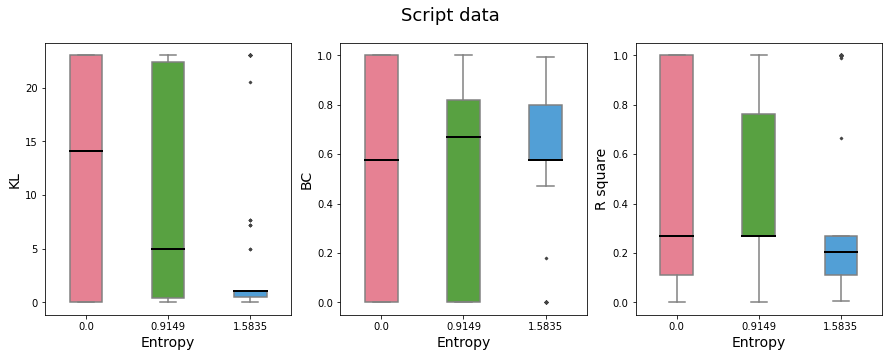

In [19]:
# def sns_vial(data):
labels = sorted(script_em['entropy'].unique())
grouped_KL = [script_em[impro_em['entropy'] == entropy]["KL_std"].values for entropy in sorted(script_em['entropy'].unique())]

for i in range(len(labels)):
    print("Number of instances for entropy = ", labels[i], ": ", len(grouped_KL[i]))

plt.figure(facecolor='white')
palette = sns.color_palette("husl",3)  # 选择一个调色板

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

boxprops = dict(edgecolor= "gray", linewidth=1.5)
whiskerprops = dict(color= "gray", linewidth=1.5)
capprops = dict(color= "gray", linewidth=1.5)

# Customize the appearance of outliers
flierprops = dict(marker='D', markersize = 2, linestyle = "none")

box1 = sns.boxplot(x='entropy', y='KL', data=script_em, ax=axs[0],palette = palette, width=0.4,
                      boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
#sns.stripplot(x='entropy', y='KL_std', data=eval_metrics_ts, ax=axs[0], color='black', jitter=True, alpha=0.4)
median_color = "black"
for i in [4, 10, 16]: 
    box1.get_lines()[i].set_color(median_color)
    box1.get_lines()[i].set_linewidth(2)
axs[0].set_ylabel('KL', fontsize = 14)
axs[0].set_xlabel('Entropy', fontsize = 14)

# BC
box2 = sns.boxplot(x='entropy', y='BC', data=script_em, ax=axs[1],palette = palette, width=0.4,
                   boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
#sns.stripplot(x='entropy', y='BC', data=eval_metrics_ts, ax=axs[1], color=".25", jitter=True, alpha=0.4)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box2.get_lines()[i].set_color(median_color)
    box2.get_lines()[i].set_linewidth(2)
axs[1].set_ylabel('BC', fontsize = 14)
axs[1].set_xlabel('Entropy', fontsize = 14)

# R Square
box3 = sns.boxplot(x='entropy', y='R_square', data=script_em, ax=axs[2],palette = palette, width=0.4,
                   boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops= flierprops)
#sns.stripplot(x='entropy', y='R_square', data=eval_metrics_ts, ax=axs[2], color=".25", jitter=True, alpha=0.4)
for i in [4, 10, 16]:  # 修改第一组、第二组和第三组的中位数线条
    box3.get_lines()[i].set_color(median_color)
    box3.get_lines()[i].set_linewidth(2)
axs[2].set_ylabel('R square', fontsize = 14)
axs[2].set_xlabel('Entropy', fontsize = 14)

plt.suptitle("Script data", fontsize = 18)
plt.show()

In [51]:
print("Script data")
print("Mean of KL score: ", round(script_em['KL'].mean(),2))
print("Mean of BC score: ", round(script_em['BC'].mean()*100,2))
print("Mean of R square: ", round(script_em['R_square'].mean()*100,2))

print("Impro data")
print("Mean of KL score: ", round(impro_em['KL'].mean(),2))
print("Mean of BC score: ", round(impro_em['BC'].mean()*100,2))
print("Mean of R square: ", round(impro_em['R_square'].mean()*100,2))

Script data
Mean of KL score:  9.51
Mean of BC score:  55.83
Mean of R square:  45.81
Impro data
Mean of KL score:  3.93
Mean of BC score:  80.08
Mean of R square:  68.88


In [61]:
len(script_em[script_em['entropy'] != 1.5835]), len(script_em)

(1801, 1922)

In [63]:
scirpt_em_2entropy = script_em[script_em['entropy'] != 1.5835]
print("Script data")
print("Number of utterances in script data without no majority voting label: ", len(scirpt_em_2entropy))
scirpt_em_2entropy['pred'] = scirpt_em_2entropy['prediction'].apply(lambda x: np.argmax(x))
scirpt_em_2entropy['true'] = scirpt_em_2entropy['ground_truth'].apply(lambda x: np.argmax(x))

print("overall acc: ", round((scirpt_em_2entropy['true'] == scirpt_em_2entropy['pred']).mean()*100,2))
print("overall W-F1: ", round(f1_score(scirpt_em_2entropy['true'], scirpt_em_2entropy['pred'], average='weighted')*100,2))

print("\n")

impro_em_2entropy = impro_em[impro_em['entropy'] != 1.5835]
print("Impro data")
print("Number of utterances in script data without no majority voting label: ", len(impro_em_2entropy))
impro_em_2entropy['pred'] = impro_em_2entropy['prediction'].apply(lambda x: np.argmax(x))
impro_em_2entropy['true'] = impro_em_2entropy['ground_truth'].apply(lambda x: np.argmax(x))

print("overall acc: ", round((impro_em_2entropy['true'] == impro_em_2entropy['pred']).mean()*100,2))
print("overall W-F1: ", round(f1_score(impro_em_2entropy['true'], impro_em_2entropy['pred'], average='weighted')*100,2))


Script data
Number of utterances in script data without no majority voting label:  1801
overall acc:  41.25
overall W-F1:  38.75


Impro data
Number of utterances in script data without no majority voting label:  2422
overall acc:  71.76
overall W-F1:  72.34


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_3727/1031935296.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scirpt_em_2entropy['pred'] = scirpt_em_2entropy['prediction'].apply(lambda x: np.argmax(x))
/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_3727/1031935296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scirpt_em_2entropy['true'] = scirpt_em_2entropy['ground_truth'].apply(lambda x: np.argmax(x))
/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_3727/10319352

In [ ]:
eval_metric = get_eval(pred, truth)
eval_metric = add_entropy(eval_metric)
entropy_vs_evalmetrics(eval_metric)
print("Mean of KL score: ", eval_metric['KL'].mean())
print("Mean of KL STD score: ", round(eval_metric['KL_std'].mean()*100,2))
print("Mean of BC score: ", round(eval_metric['BC'].mean()*100,2))
print("Mean of R square: ", round(eval_metric['R_square'].mean()*100,2))
pred = np.array(pred)
truth = np.array(truth)
maj_pred_prob, maj_truth_prob, maj_pred_label, maj_truth_label = majority_agree(pred, truth)
ece = ECE(pred, truth)
acc = accuracy_score(maj_truth_label, maj_pred_label)
print("ECE: ", round(ece[0]*100,2))
print("UAC: ", round(acc*100,2))
w_f1 = f1_score(maj_truth_label, maj_pred_label, average='weighted')
print("Weighted F1: ", round(w_f1*100,2))

Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  6.38670009153318
Mean of KL STD score:  27.74
Mean of BC score:  69.41
Mean of R square:  58.73
ECE:  28.88
UAC:  57.96
Weighted F1:  58.33
overall acc:  58.75
overall W-F1:  59.06
entropy = 0.0: acc =  67.93
entropy = 0.9149: acc =  46.55
entropy = 0.0: W-F1 = : 68.55
entropy = 0.9149: W-F1 =  46.64


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_3727/2265982583.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_entropy = d_e.apply(lambda x: round((x['true'] == x['pred']).mean()*100,2))
/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_3727/2265982583.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_by_group = d_e.apply(lambda x: round(f1_score(x['true'], x['pred'], 

<Figure size 432x288 with 0 Axes>

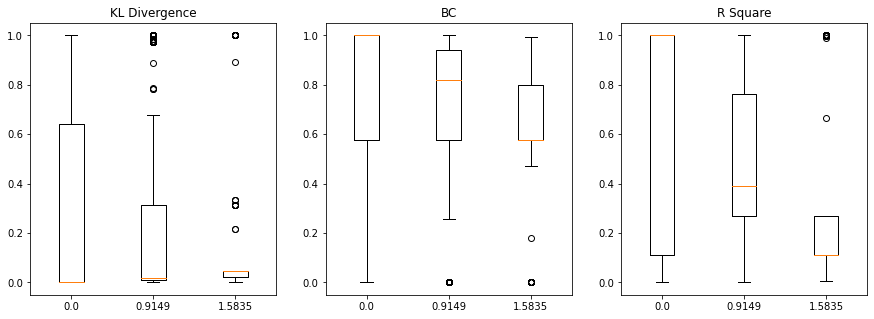

In [108]:
d = whole_eval("0831_c20_fs_at")
cal_vote_by_entropy(d)

Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  7.713840732265446
Mean of KL STD score:  33.5
Mean of BC score:  61.06
Mean of R square:  55.32
ECE:  40.19
UAC:  53.52
Weighted F1:  53.99
overall acc:  54.42
overall W-F1:  54.7
entropy = 0.0: acc =  62.49
entropy = 0.9149: acc =  43.68
entropy = 0.0: W-F1 = : 62.99
entropy = 0.9149: W-F1 =  44.31


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_3727/2265982583.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_entropy = d_e.apply(lambda x: round((x['true'] == x['pred']).mean()*100,2))
/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_3727/2265982583.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_by_group = d_e.apply(lambda x: round(f1_score(x['true'], x['pred'], 

<Figure size 432x288 with 0 Axes>

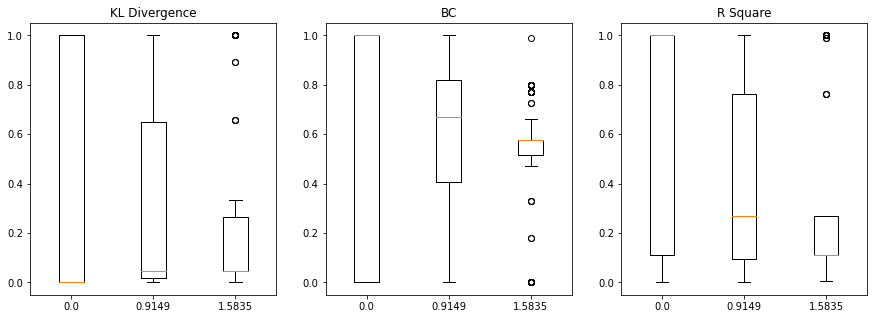

In [104]:
d = whole_eval("0830_c5_fewshot_v2")
cal_vote_by_entropy(d)

context = 5, text only. zero-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  11.383449542334096
Mean of KL STD score:  49.44
Mean of BC score:  45.7
Mean of R square:  48.35
ECE:  56.49
UAC:  41.17
Weighted F1:  41.04


<Figure size 432x288 with 0 Axes>

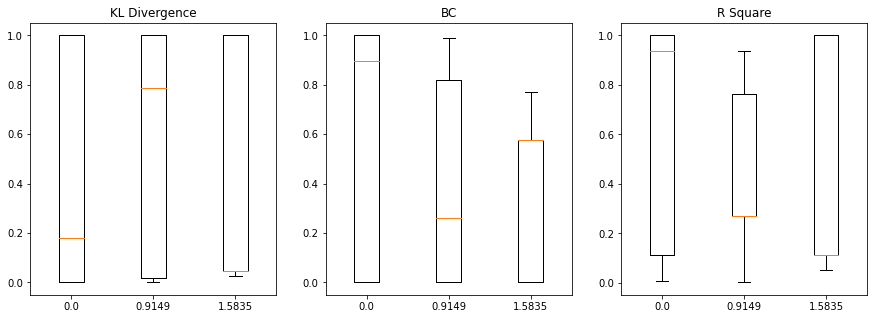

In [68]:
print("context = 5, text only. zero-shot")
a = whole_eval("0901_c5_text")

Context = 5, audio+text, few-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  3.907388352402746
Mean of KL STD score:  33.94
Sum of BC score:  61.06
Sum of R square:  55.32
ECE:  40.19
UAC:  53.52
Weighted F1:  53.99


<Figure size 432x288 with 0 Axes>

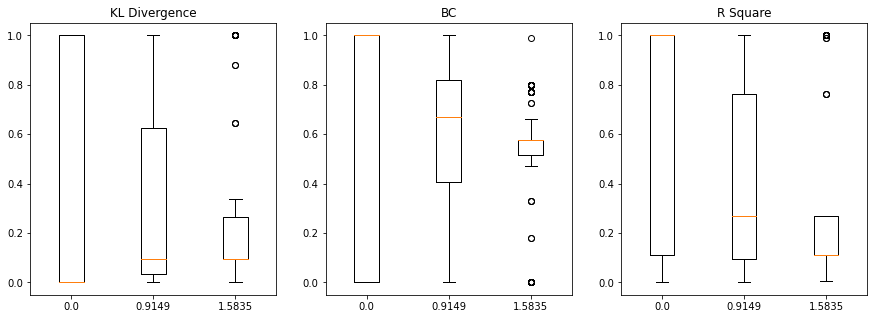

In [74]:
print("Context = 5, audio+text, few-shot")
a = whole_eval("0830_c5_fewshot_v2")

Context = 10, audio + text, 0-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  5.1415799313501145
Mean of KL STD score:  44.66
Sum of BC score:  50.45
Sum of R square:  50.66
ECE:  52.28
UAC:  45.51
Weighted F1:  46.56


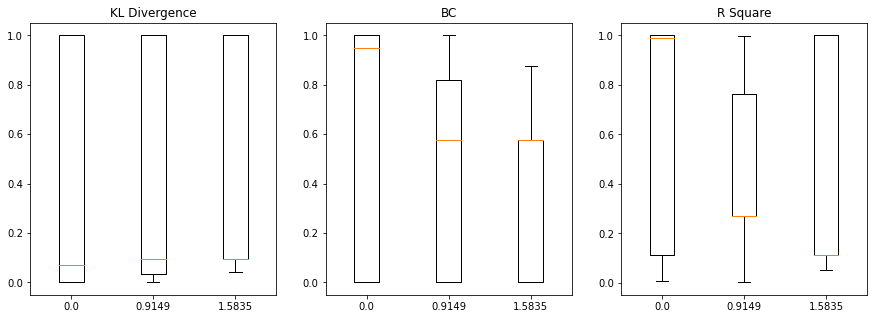

In [52]:
print("Context = 10, audio + text, 0-shot")
eval_metrics_c10_a = whole_eval("0831_c10_audio")

context = 10, audio+text, few-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  3.4149015789473687
Mean of KL STD score:  29.66
Sum of BC score:  66.11
Sum of R square:  57.81
ECE:  34.11
UAC:  56.68
Weighted F1:  56.85


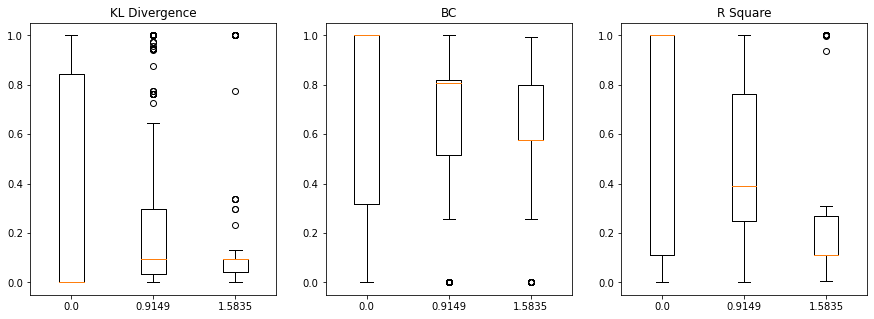

In [53]:
print("context = 10, audio+text, few-shot")
eval_metrics_c10_fs = whole_eval("0831_c10_fewshot")

context = 15, aduio+text, few-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  3.304992196796339
Mean of KL STD score:  28.71
Sum of BC score:  67.84
Sum of R square:  58.05
ECE:  31.79
UAC:  56.64
Weighted F1:  56.85


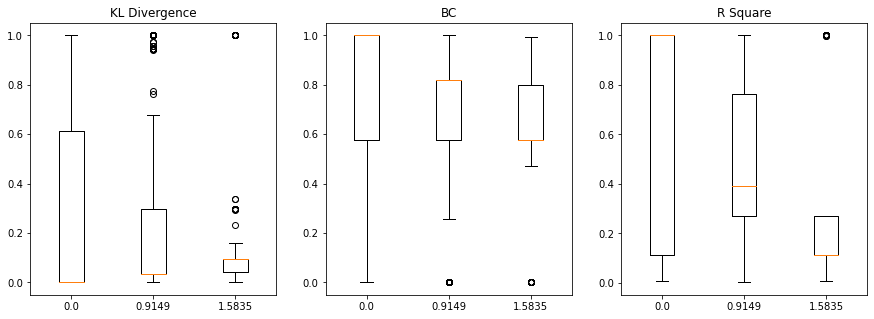

In [61]:
print("context = 15, aduio+text, few-shot")
eval_metrics_c10_text = whole_eval("0831_c15_fewshot")

context = 20, text only, zero-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  5.709281578947368
Mean of KL STD score:  49.59
Sum of BC score:  45.95
Sum of R square:  48.87
ECE:  56.2
UAC:  41.97
Weighted F1:  41.29


<Figure size 432x288 with 0 Axes>

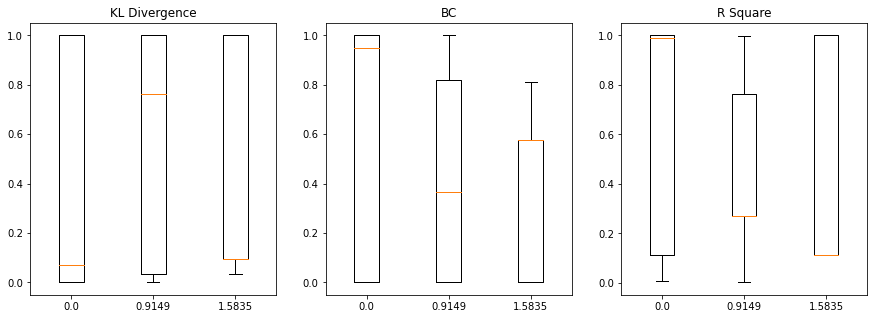

In [80]:
print("context = 20, text only, zero-shot")
a =whole_eval("0901_c20_text")


context = 20, aduio+text, few-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  3.195699748283753
Mean of KL STD score:  27.76
Mean of BC score:  69.41
Mean of R square:  58.73
ECE:  28.88
UAC:  57.96
Weighted F1:  58.33


<Figure size 432x288 with 0 Axes>

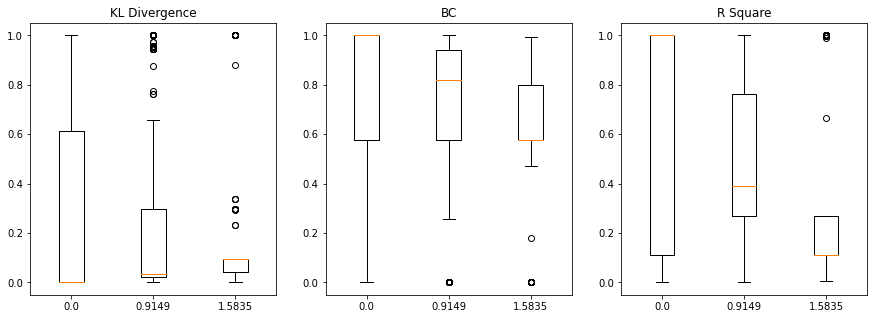

In [116]:
print("context = 20, aduio+text, few-shot")
eval_metrics_c20_fs_at = whole_eval("0831_c20_fs_at")

* KL_std (1.000000) : ground truth and prediction are two totally different distribution
* KL_std (0.96329367)
* KL_std (0.956545) : ground truth ([0.0, 1.0, 0.0, 0.0]), prediction ([0.0, 0.0, 0.8, 0.2])
* KL_std (0.94695562) 
* KL_std (0.9445149)
* KL_std (0.904603): ground truth ([0.0, 1.0, 0.0, 0.0]), prediction ([0.33, 0.0, 0.33, 0.34])
* KL_std (0.614931) : ground truth ([0.0, 1.0, 0.0, 0.0]), prediction ([0.67, 0.33, 0.0, 0.0])

 0.75655346, 0.94493182,
       0.70117259, 0.87177973, 0.8445149 , , 0.89468427

In [121]:
eval_metrics_c20_fs_at.loc[(eval_metrics_c20_fs_at['entropy'] == 0.0000) & 
                                         (eval_metrics_c20_fs_at['KL_std'] == 0.614931)]

,ground_truth,prediction,KL,BC,R_square,KL_std,entropy
43,"[0.0, 1.0, 0.0, 0.0]","[0.67, 0.33, 0.0, 0.0]",7.0796,0.5745,0.0277,0.614931,0.0
60,"[0.0, 1.0, 0.0, 0.0]","[0.67, 0.33, 0.0, 0.0]",7.0796,0.5745,0.0277,0.614931,0.0
88,"[0.0, 0.0, 1.0, 0.0]","[0.67, 0.0, 0.33, 0.0]",7.0796,0.5745,0.0277,0.614931,0.0
179,"[0.0, 1.0, 0.0, 0.0]","[0.67, 0.33, 0.0, 0.0]",7.0796,0.5745,0.0277,0.614931,0.0
184,"[0.0, 1.0, 0.0, 0.0]","[0.67, 0.33, 0.0, 0.0]",7.0796,0.5745,0.0277,0.614931,0.0
...,...,...,...,...,...,...,...
4331,"[0.0, 1.0, 0.0, 0.0]","[0.67, 0.33, 0.0, 0.0]",7.0796,0.5745,0.0277,0.614931,0.0
4332,"[0.0, 1.0, 0.0, 0.0]","[0.67, 0.33, 0.0, 0.0]",7.0796,0.5745,0.0277,0.614931,0.0
4333,"[0.0, 1.0, 0.0, 0.0]","[0.67, 0.33, 0.0, 0.0]",7.0796,0.5745,0.0277,0.614931,0.0
4337,"[0.0, 1.0, 0.0, 0.0]","[0.67, 0.33, 0.0, 0.0]",7.0796,0.5745,0.0277,0.614931,0.0


context = 20, only text, few-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  3.5097947826086955
Mean of KL STD score:  30.49
Sum of BC score:  66.67
Sum of R square:  57.9
ECE:  30.73
UAC:  56.96
Weighted F1:  57.6


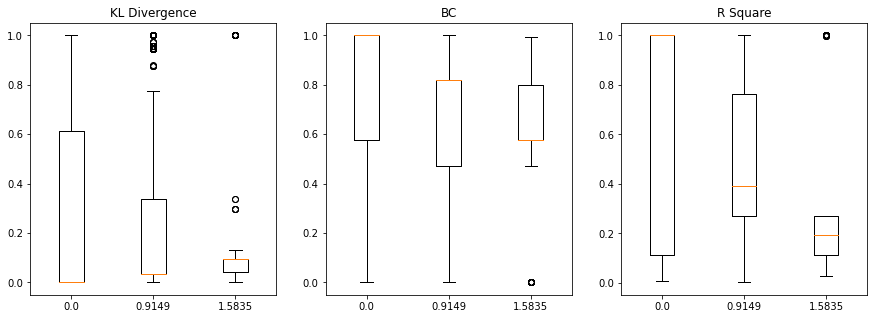

In [68]:
print("context = 20, only text, few-shot")
a = whole_eval("0901_c20_fs_noaudio")

context = 20, audio+text, zero-shot


/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: divide by zero encountered in log
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))
/Users/macbookpro/Documents/Research Project/LLM_Ambiguous_Emotion/eval_metrics.py:12: RuntimeWarning: invalid value encountered in multiply
  KL_value = np.sum(np.where(a != 0, a * np.log(a / b), 0))


Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of JS 0.47
Mean of BC score:  0.51
Mean of R square:  0.51
ECE:  51.21
UAC:  46.75
Weighted F1:  47.89


<Figure size 432x288 with 0 Axes>

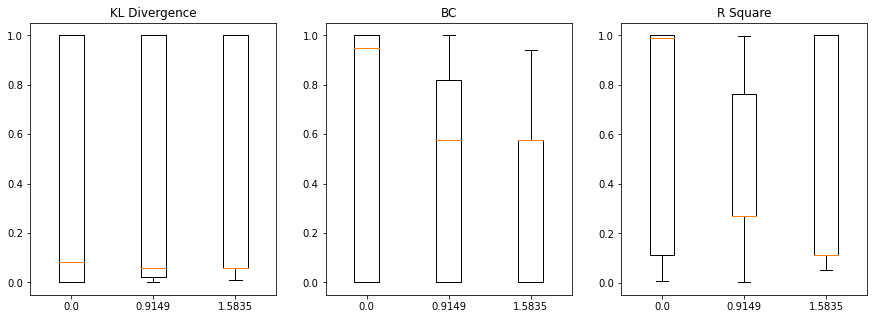

In [14]:
print("context = 20, audio+text, zero-shot")
a = whole_eval("0901_c20_audio")

context = 25, aduio+text, few-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  3.265397254004577
Mean of KL STD score:  28.36
Sum of BC score:  69.53
Sum of R square:  58.45
ECE:  27.77
UAC:  57.39
Weighted F1:  57.9


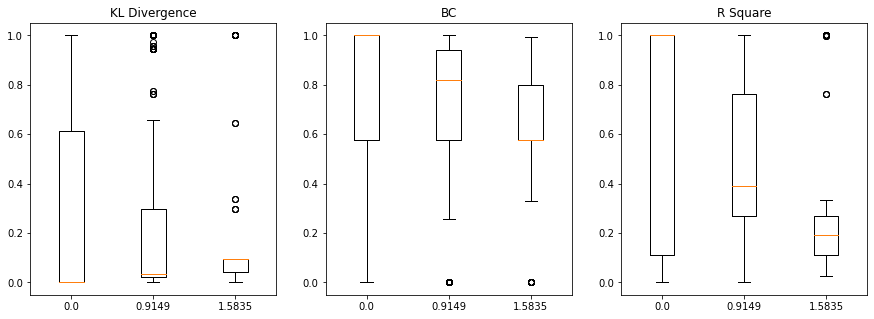

In [63]:
print("context = 25, aduio+text, few-shot")
eval_metrics_c10_text = whole_eval("0831_c25_fs_at")

context = 30, aduio+text, few-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  3.268999908466819
Mean of KL STD score:  28.39
Sum of BC score:  69.71
Sum of R square:  58.13
ECE:  26.91
UAC:  57.35
Weighted F1:  58.0


<Figure size 432x288 with 0 Axes>

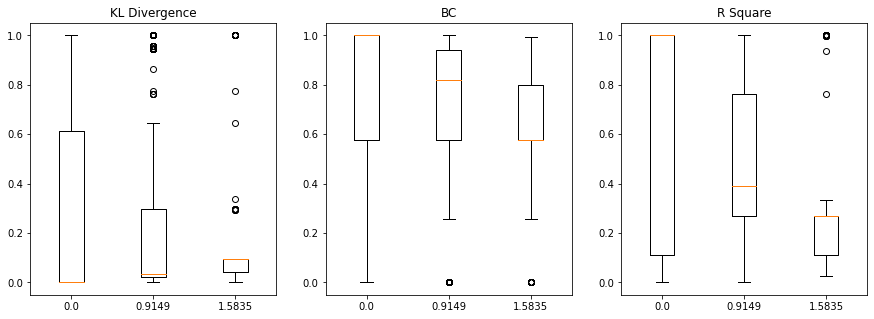

In [75]:
print("context = 30, aduio+text, few-shot")
eval_metrics_c10_text = whole_eval("0831_c30_fs_at")

context = 5, text only, few shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  4.223305469107552
Mean of KL STD score:  36.68
Sum of BC score:  58.73
Sum of R square:  54.82
ECE:  42.32
UAC:  51.88
Weighted F1:  52.88


<Figure size 432x288 with 0 Axes>

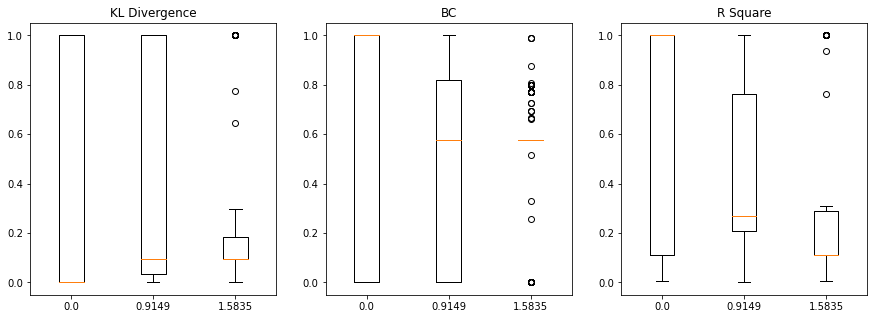

In [79]:
print("context = 5, text only, few shot")
a = whole_eval("0831_c5_fs_noaudio")

context = 5, audio+text, zero shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  5.1841911441647595
Mean of KL STD score:  45.03
Sum of BC score:  49.91
Sum of R square:  49.84
ECE:  52.79
UAC:  44.76
Weighted F1:  45.7


<Figure size 432x288 with 0 Axes>

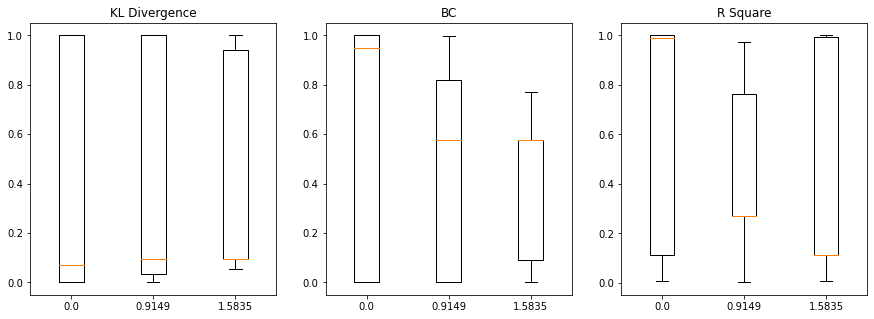

In [78]:
print("context = 5, audio+text, zero shot")
eval_metrics_c10_fs_text = whole_eval("0830_c5_audio")

context = 5, few show, only text
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  4.223305469107552
Mean of KL STD score:  36.68
Sum of BC score:  58.73
Sum of R square:  54.82
ECE:  42.32
UAC:  51.88
Weighted F1:  52.88


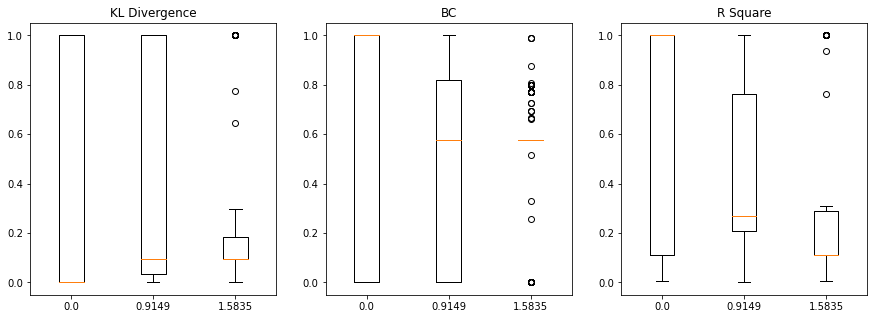

In [55]:
print("context = 5, few show, only text")
eval_metrics_c5_fs_text = whole_eval("0831_c5_fs_noaudio")

context = 15, aduio+text, few-shot
Number of instances for entropy =  0.0 :  2410
Number of instances for entropy =  0.9149 :  1813
Number of instances for entropy =  1.5835 :  147
Mean of KL score:  3.304992196796339
Mean of KL STD score:  28.71
Sum of BC score:  67.84
Sum of R square:  58.05
ECE:  31.79
UAC:  56.64
Weighted F1:  56.85


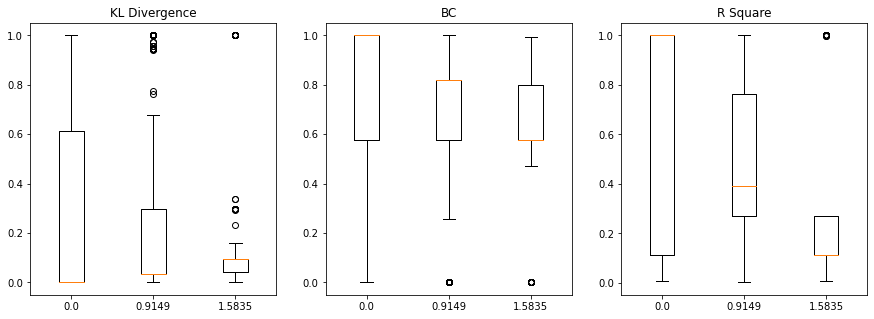

In [59]:
print("context = 15, audio+text, few shot")
eval_metrics = whole_eval("0831_c15_fewshot")

context = 15, audio+text, few shot


FileNotFoundError: [Errno 2] No such file or directory: './prediction/0831_c15_fewshot/pred.csv'